# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [11]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [12]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [13]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(df, ['label', 'filename'], 0.2, 0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train, y_train, X_test, y_test):
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [15]:
input_dim = X_train_scaled.shape[1]
hidden_dim = 128
output_dim = 1
lr=0.001

model = MLP(no_features=input_dim, no_hidden=hidden_dim, no_labels=output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [16]:
from common_utils import EarlyStopper  # assuming EarlyStopper is available in this module
import torch

# Training function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()

    for X, y in dataloader:
        pred = model(X).reshape(-1)
        loss = loss_fn(pred, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    train_loss /= size
    train_acc = correct / size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).reshape(-1)
            test_loss += loss_fn(pred, y.float()).item() * X.size(0)
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct / size
    return test_loss, test_acc

train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0)

for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_.append(train_loss)
    train_acc_.append(train_acc)
    test_loss_.append(test_loss)
    test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}, train_loss {train_loss:.6f}, train_acc {train_acc:.4f}, "
          f"test_loss {test_loss:.6f}, test_acc {test_acc:.4f}")

    if early_stopper.early_stop(test_loss):
        print("Early stopping!")
        break

print("Training complete!")

Epoch 1, train_loss 0.684294, train_acc 0.5586, test_loss 0.678832, test_acc 0.5638
Epoch 2, train_loss 0.666483, train_acc 0.5894, test_loss 0.661866, test_acc 0.5949
Epoch 3, train_loss 0.647920, train_acc 0.6210, test_loss 0.650701, test_acc 0.6186
Epoch 4, train_loss 0.632840, train_acc 0.6382, test_loss 0.638889, test_acc 0.6327
Epoch 5, train_loss 0.612263, train_acc 0.6621, test_loss 0.627656, test_acc 0.6376
Epoch 6, train_loss 0.595603, train_acc 0.6761, test_loss 0.603562, test_acc 0.6862
Epoch 7, train_loss 0.579395, train_acc 0.6907, test_loss 0.593916, test_acc 0.6882
Epoch 8, train_loss 0.563776, train_acc 0.7006, test_loss 0.589821, test_acc 0.6828
Epoch 9, train_loss 0.544695, train_acc 0.7182, test_loss 0.574728, test_acc 0.7023
Epoch 10, train_loss 0.526216, train_acc 0.7350, test_loss 0.552254, test_acc 0.7260
Epoch 11, train_loss 0.511228, train_acc 0.7414, test_loss 0.552794, test_acc 0.7210
Epoch 12, train_loss 0.503092, train_acc 0.7502, test_loss 0.545942, test_

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

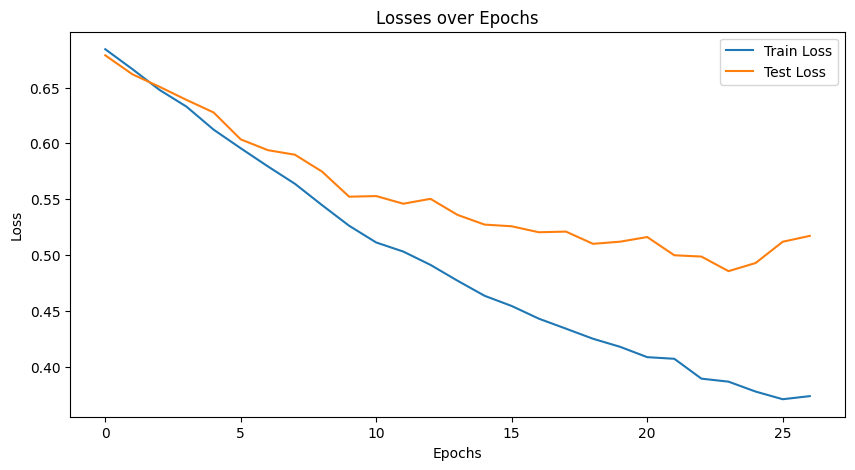

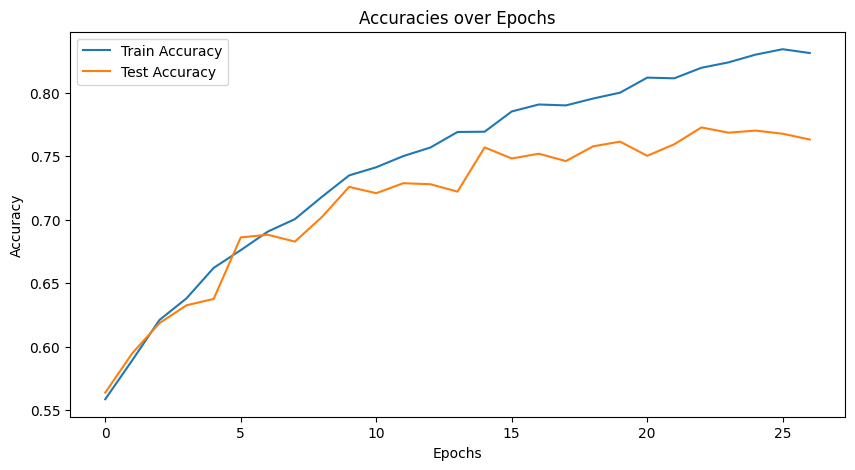

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_, label='Train Loss')
plt.plot(test_loss_, label='Test Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_, label='Train Accuracy')
plt.plot(test_acc_, label='Test Accuracy')
plt.title('Accuracies over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


6.Comment on line plots.

In [19]:
# YOUR CODE HERE
answer = """
- Training loss decreases over time because the model is continuously adjusting its parameters using gradient descent to minimize the loss function. The test loss should ideally decrease as well if the model is generalizing well to unseen data. A small gap between training and test losses suggests that the model is not overfitting and is generalizing well.

- The increase in accuracy on both the training and test sets indicates that the model is learning to make more correct predictions over time.

- Since the patience is set to 3, the model was allowed to continue training for 3 epochs without improvement in the test loss. The model stops early after 27 epochs, it means that the test loss did not improve after epooch 24, and early stopping was triggered. This suggests the model had already converged, and continue training may introduce overfitting."""